In [1]:
%load_ext autoreload
%autoreload 2
%load_ext functionizer

In [2]:
def save_fig(fig, name):
    fig.savefig(rf"C:\Users\wuyua\OneDrive - The University of Western Ontario\Research\crm\paper\figure\{name}.png", bbox_inches="tight")

In [3]:
from solvers import agglomeration_grid_1d, agglomeration_pa_1d
from compress import compress
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from scipy.integrate import trapz
from scipy.stats import binned_statistic
import pandas as pd

In [4]:
L_edges = np.linspace(0, 10, 100)
L_centers = 0.5 * (L_edges[1:] + L_edges[:-1])

N0 = 1e11
L0 = 1.5

z = L_centers / L0

dt = 1.
t_total = 320.
kernel_coef = 6e-13

n_init = N0/L0 * z**2 * np.exp(-z**3)

In [5]:
n = n_init.copy()
pbar = tqdm(total=t_total)
t = 0
ts_grid = [t]
vols_grid = [trapz(n * L_centers**3, L_centers)]
cnts_grid = [trapz(n, L_centers)]
while t < t_total:
    B, D = agglomeration_grid_1d(n, L_edges, L_centers, kernel_coef, aggl_dim_power=3)
    n += (B - D) * dt
    t += dt
    # assert np.isclose(B.sum() * 2, D.sum())
    pbar.update(dt)
    vols_grid.append(trapz(n * L_centers**3, L_centers))
    cnts_grid.append(trapz(n, L_centers))
    ts_grid.append(t)
pbar.close()

  0%|          | 0/320.0 [00:00<?, ?it/s]

In [6]:
N = np.vstack([L_centers, n_init*np.diff(L_edges)]).T
N = N[N[:, -1] > 0]

pbar = tqdm(total=t_total)
t = 0

ts_pa = [0]
vols_pa = [(N[:, 0]**3 * N[:, -1]).sum()]
cnts_pa = [N[:, -1].sum()]
while t < t_total:
    B, D = agglomeration_pa_1d(N, kernel_coef, dim_powers=np.array([3.]), min_count=1e-3, aggl_dim=0)
    assert np.isclose((N[:, 0]**3 * D).sum(), (B[:, 0]**3 * B[:, -1]).sum())
    N[:, -1] -= dt * D
    B[:, -1] *= dt
    N = np.vstack((N, B))
    N = compress(N, 0.1, np.array([3]), 1)
    t += dt
    pbar.update(dt)
    vols_pa.append((N[:, 0]**3 * N[:, -1]).sum())
    cnts_pa.append(N[:, -1].sum())
    ts_pa.append(t)
pbar.close()

  0%|          | 0/320.0 [00:00<?, ?it/s]

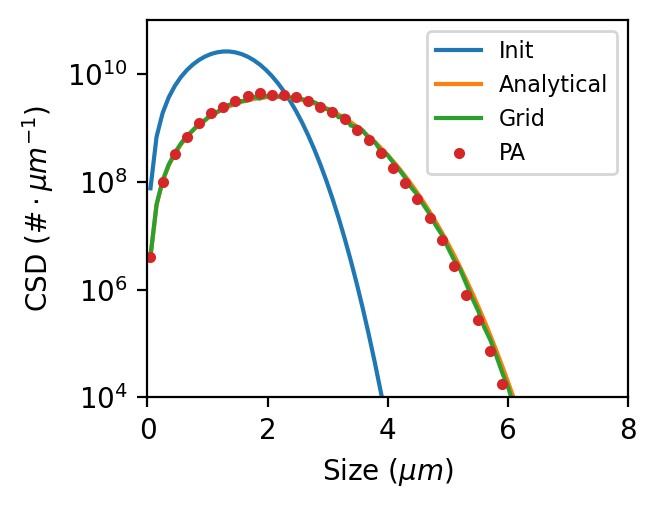

In [7]:
fig, ax = plt.subplots(dpi=200, figsize=(3.1, 2.5))
ax.plot(L_centers, n_init, label="Init")
Y = 6.6
n_end = 4 * N0 * z**2 / (L0 * (Y+2)**2) * np.exp(-2*z**3/(Y+2))

ax.plot(L_centers, n_end, label="Analytical")
ax.plot(L_centers, n, label="Grid")


grid = np.linspace(0, 10, 100)
stats, xe, bn = binned_statistic(N[:, 0], N[:, 1], statistic="sum", bins=grid)
xc = 0.5*(xe[1:] + xe[:-1])
nd = stats / (xe[1:] - xe[:-1])
ax.plot(xc, nd, ".", markevery=2, label="PA")

ax.set_xlabel("Size $(\mu m)$")
ax.set_ylabel("CSD $(\#\cdot \mu m^{-1})$")
ax.legend(fontsize=8)
ax.set_yscale("log")
ax.set_ylim([1e4, 1e11])
ax.set_xlim([0, 8])

save_fig(fig, "agglomeration_linear_grid")

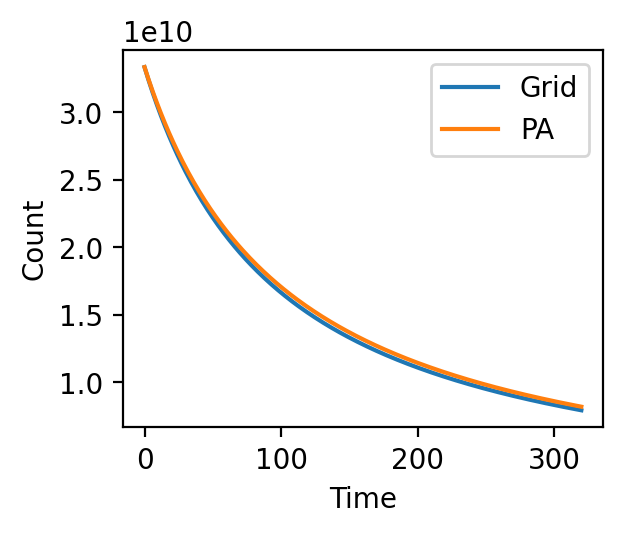

In [8]:
fig, ax = plt.subplots(dpi=200, figsize=(3.1, 2.5))
ax.plot(ts_grid, cnts_grid, label="Grid")
ax.plot(ts_pa, cnts_pa, label="PA")
ax.set_xlabel("Time")
ax.set_ylabel("Count")
ax.legend()

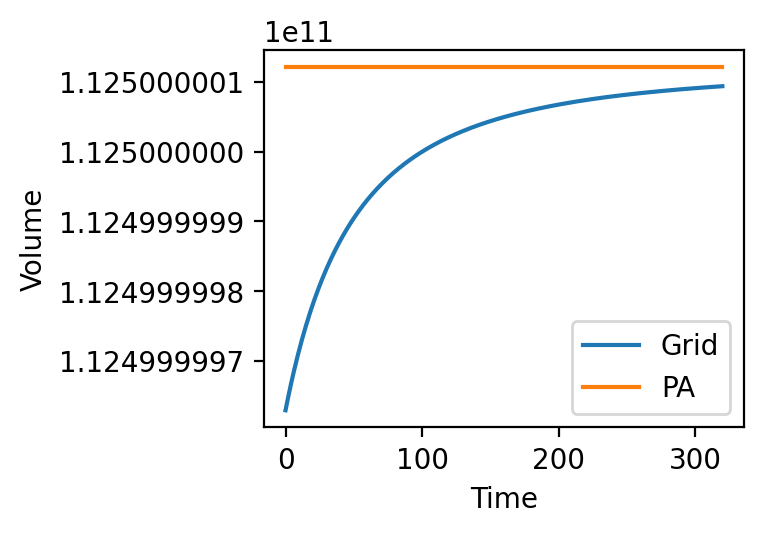

In [9]:
fig, ax = plt.subplots(dpi=200, figsize=(3.1, 2.5))
ax.plot(ts_grid, vols_grid, label="Grid")
ax.plot(ts_pa, vols_pa, label="PA")
ax.set_xlabel("Time")
ax.set_ylabel("Volume")
ax.legend()
ax.ticklabel_format(useOffset=False)

In [16]:
v_edges = np.logspace(-5, 9, 200)
v_centers = 0.5 * (v_edges[1:] + v_edges[:-1])

N0 = 1e0
v0 = 1.0

z = v_centers / v0

dt = 1
t_total = 300
kernel_coef = 1e-2

n_init = N0 * v_centers/v0 * np.exp(-v_centers/v0)

M0 = 2*N0 / (2 + kernel_coef * N0 * t_total)
T = 1 -  M0/ N0
# n_final = N0 / v0 * (1-T)**2 * np.exp(-v_centers/v0*(1-T))
n_final = N0 *(1-T)**2 / (v0* T**0.5) * np.exp(-v_centers/v0) * np.sinh(v_centers/v0*T**0.5)

<ipython-input-16-04b95d44a7a6>:18: RuntimeWarning: overflow encountered in sinh
  n_final = N0 *(1-T)**2 / (v0* T**0.5) * np.exp(-v_centers/v0) * np.sinh(v_centers/v0*T**0.5)
<ipython-input-16-04b95d44a7a6>:18: RuntimeWarning: invalid value encountered in multiply
  n_final = N0 *(1-T)**2 / (v0* T**0.5) * np.exp(-v_centers/v0) * np.sinh(v_centers/v0*T**0.5)


In [17]:
n = n_init.copy()

pbar = tqdm(total=t_total)
t = 0
ts_grid = [t]
vols_grid = [trapz(n * v_centers, v_centers)]
cnts_grid = [trapz(n, v_centers)]
while t < t_total:
    B, D = agglomeration_grid_1d(n, v_edges, v_centers, kernel_coef, aggl_dim_power=1, min_count=1e-16)
    n += (B - D) * dt
    t += dt
    # assert np.isclose(B.sum() * 2, D.sum())
    pbar.update(dt)
    vols_grid.append(trapz(n * v_centers, v_centers))
    cnts_grid.append(trapz(n, v_centers))
    ts_grid.append(t)
pbar.close()


  0%|          | 0/300 [00:00<?, ?it/s]

In [18]:
N = np.vstack([v_centers, n_init*np.diff(v_edges)]).T
N = N[N[:, -1] > 1e-16]

pbar = tqdm(total=t_total)
t = 0
ts_pa = [0]
vols_pa = [(N[:, 0] * N[:, -1]).sum()]
cnts_pa = [N[:, -1].sum()]
while t < t_total:
    B, D = agglomeration_pa_1d(N, kernel_coef, dim_powers=np.array([1.]), min_count=1e-16)
    N[:, -1] -= dt * D
    assert np.all(N[:, -1] > 0)
    B[:, -1] *= dt
    N = np.vstack((N, B))
    N = compress(N, 0.1, np.array([1]), 1, log=True)
    t += dt
    pbar.update(dt)
    vols_pa.append((N[:, 0] * N[:, -1]).sum())
    cnts_pa.append(N[:, -1].sum())
    ts_pa.append(t)
pbar.close()

  0%|          | 0/300 [00:00<?, ?it/s]

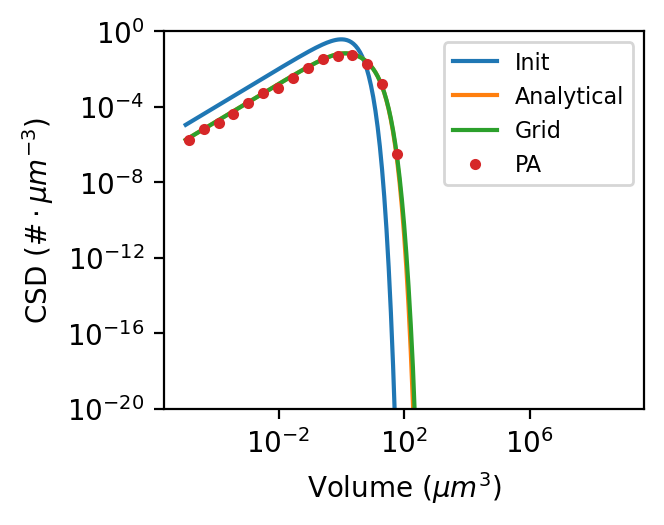

In [19]:
fig, ax = plt.subplots(dpi=200, figsize=(3.1, 2.5))
ax.plot(v_centers, n_init, label="Init")
ax.plot(v_centers, n_final, label="Analytical")
ax.plot(v_centers, n, label="Grid")

grid = np.logspace(-5, 9, 60)
stats, xe, bn = binned_statistic(N[:, 0], N[:, 1], statistic="sum", bins=grid)
xc = 0.5*(xe[1:] + xe[:-1])
nd = stats / (xe[1:] - xe[:-1])
ax.plot(xc, nd, ".", markevery=2, label="PA")

ax.set_xlabel("Volume $(\mu m ^3)$")
ax.set_ylabel("CSD $(\#\cdot \mu m^{-3})$")
ax.legend(fontsize=8)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim([1e-20, 1])

save_fig(fig, "agglomeration_volume_log")



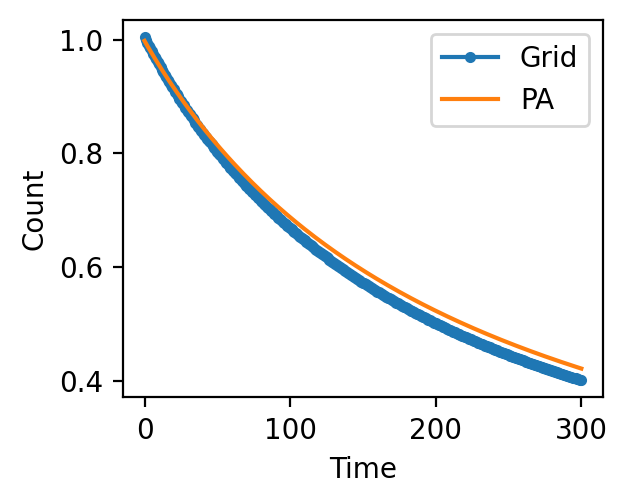

In [20]:
fig, ax = plt.subplots(dpi=200, figsize=(3.1, 2.5))
ax.plot(ts_grid, cnts_grid, ".-", label="Grid")
ax.plot(ts_pa, cnts_pa, label="PA")
ax.set_xlabel("Time")
ax.set_ylabel("Count")
ax.legend()

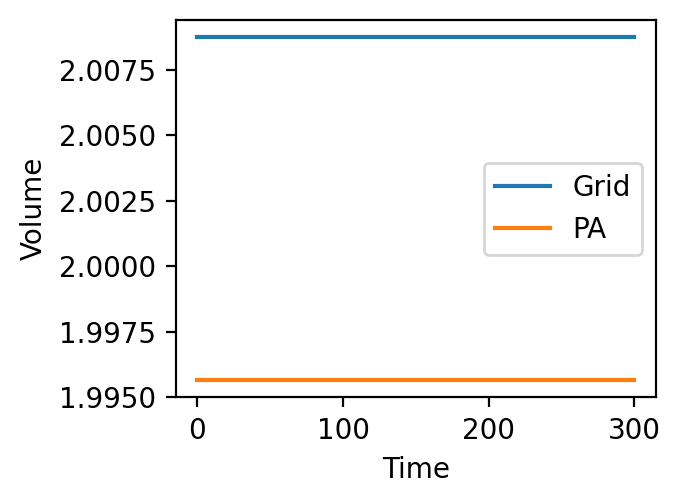

In [21]:
fig, ax = plt.subplots(dpi=200, figsize=(3.1, 2.5))
ax.plot(ts_grid, vols_grid, label="Grid")
ax.plot(ts_pa, vols_pa, label="PA")
ax.set_xlabel("Time")
ax.set_ylabel("Volume")
ax.legend()
ax.ticklabel_format(useOffset=False)


